In [184]:
import tensorflow as tf
import os 
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import keras
from keras.src.utils import image_dataset_from_directory

%matplotlib inline
import numpy as np
from tf_keras.models import Sequential
from tf_keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tf_keras.callbacks import TensorBoard
from tf_keras.metrics import Precision, Recall,BinaryAccuracy

In [2]:
data_dir = 'data'

In [3]:
image_exts = ['jpg', 'jpeg', 'png','bmp']

In [4]:
os.listdir(os.path.join(data_dir,'happy'))


['image34.jpeg',
 '05-12-21-happy-people.jpg',
 'image22.jpeg',
 'Happy.jpg',
 '-businesspeople-choose-you-for-employment-or-recruitment-illustration-vector.jpg',
 'py-company-team-colleagues-jumping-flat-winning-characters-collection-vector.jpg',
 '1687d86811a2c25b877448ed47218131.jpg',
 '170404-happy-workers-feature.jpg',
 'friends-youth-happy-people-cartoon-W80EC5.jpg',
 'MV5BZGU2MDhjZjQtMDAxZS00MDVjLTk0NTUtNTliYzNmODc1ODFiXkEyXkFqcGc._V1_.jpg',
 'friends-happy-190821.jpg',
 'stock-photo-group-of-happy-people-isolated-over-white-background-102307264.jpg',
 'MV5BM2IzZGNkZmEtNDY1OS00ZmYyLTk3MmQtNTI4NzM4MTIzODAxXkEyXkFqcGc._V1_.jpg',
 'image38.jpeg',
 'goup-happy-people-group-jumping-isolated-white-background-35582232.jpg',
 'tjhu4mgslz4.jpg',
 'maxresdefault2.jpg',
 'habits-of-happy-people-jpg.jpg',
 '.DS_Store',
 'iStock-1207566766.jpg',
 'friends_190412.jpg',
 'pngtree-team-of-happy-people-png-image_7800848.png',
 'aecd7b04-bb40-42ad-9985-d63a3198a878.jpg',
 'happy-people-celebratin

In [5]:
img = cv2.imread(os.path.join('data','happy', 'smile.woman_.jpg'))

In [6]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(class_path):  # Check if it's a directory
        for image in os.listdir(class_path):
            if image != '.DS_Store':  # Exclude .DS_Store
                image_path = os.path.join(class_path, image)
                try:
                    # Use PIL to open the image
                    img = Image.open(image_path)
                    img_format = img.format.lower()  # Get the image format
                    if img_format not in image_exts:
                        print("Image not found: {}".format(image_path))
                        os.remove(image_path)
                except Exception as e:
                    print("Issue with image {}: {}".format(image_path, e))


## Load data

In [78]:
data = image_dataset_from_directory('data')

Found 181 files belonging to 2 classes.


In [41]:
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x32464f010>)

In [42]:
# Img as np array
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

In [43]:
 # labels
 # class 1 = sad
 # class 2 = happy
 batch[1]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

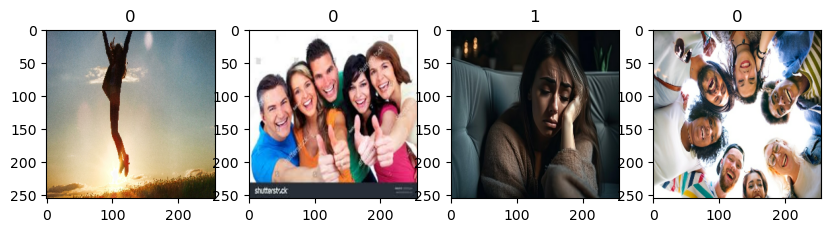

In [44]:
fig, ax = plt.subplots(ncols=4,figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocess data 

In [54]:
print(batch[0].max()) # 0,255
scaled = batch[0] / 255
print(scaled.max()) # scaled ; 0,1

255.0
1.0


In [79]:
data = data.map(lambda x,y: (x/255,y))
scaled_iterator = data.as_numpy_iterator()

In [80]:
batch = scaled_iterator.next()

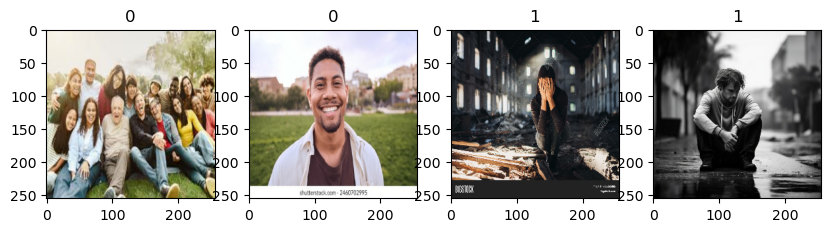

In [83]:
fig, ax = plt.subplots(ncols=4,figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Split data

In [86]:
len(data)

6

In [105]:
train_size = int(len(data)*.7) -1
val_size = int(len(data)*.2) +1
test_size = int(len(data)*.1) + 1

In [106]:
val_size + train_size + test_size

6

In [110]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


# Build dl model

In [148]:
model = Sequential([
    Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)),
    MaxPooling2D((2,2)),
    
    Conv2D(32,(3,3),1,activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(16,(3,3),1,activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(256,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.compile('adam',loss=keras.src.losses.BinaryCrossentropy(),metrics=['accuracy'])


In [149]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 30, 30, 16)      

# train

In [171]:
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)

In [172]:
hist = model.fit(train,
                 epochs=20,
                 validation_data=val,
                 callbacks=[tensorboard_callback])



Epoch 1/20
3/3 [==============================] - 2s 470ms/step - loss: 1.3436 - accuracy: 0.5729 - val_loss: 1.0442 - val_accuracy: 0.4375
Epoch 2/20
3/3 [==============================] - 2s 560ms/step - loss: 0.8255 - accuracy: 0.4792 - val_loss: 0.6547 - val_accuracy: 0.5469
Epoch 3/20
3/3 [==============================] - 2s 500ms/step - loss: 0.6620 - accuracy: 0.5521 - val_loss: 0.6278 - val_accuracy: 0.5469
Epoch 4/20
3/3 [==============================] - 1s 447ms/step - loss: 0.5987 - accuracy: 0.6042 - val_loss: 0.5769 - val_accuracy: 0.8438
Epoch 5/20
3/3 [==============================] - 2s 512ms/step - loss: 0.5867 - accuracy: 0.6979 - val_loss: 0.5144 - val_accuracy: 0.7344
Epoch 6/20
3/3 [==============================] - 2s 582ms/step - loss: 0.5091 - accuracy: 0.8021 - val_loss: 0.4673 - val_accuracy: 0.8438
Epoch 7/20
3/3 [==============================] - 2s 464ms/step - loss: 0.4415 - accuracy: 0.8542 - val_loss: 0.3876 - val_accuracy: 0.8906
Epoch 8/20
3/3 [====

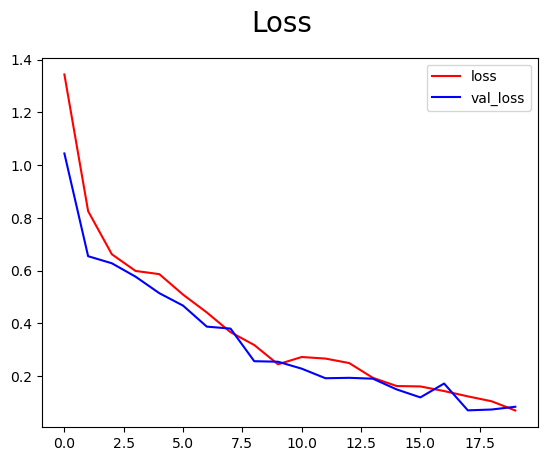

In [181]:
fig = plt.figure()
plt.plot(hist.history['loss'], color= 'red', label ='loss')
plt.plot(hist.history['val_loss'], color= 'blue', label ='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()


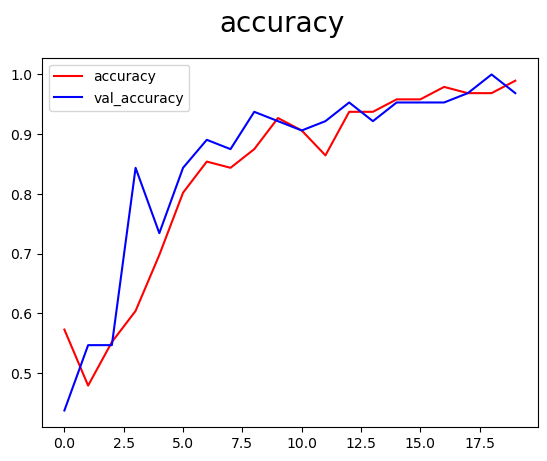

In [183]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color= 'red', label ='accuracy')
plt.plot(hist.history['val_accuracy'], color= 'blue', label ='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()


# Evaluate 

In [188]:
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [203]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    prec.update_state(y,yhat)
    rec.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 58ms/step


In [212]:
print(f'Precision: {prec.result()},\nRecall: {rec.result()}, \nAccuracy: {acc.result()}')

Precision: 1.0,
Recall: 0.8857142925262451, 
Accuracy: 0.9523809552192688


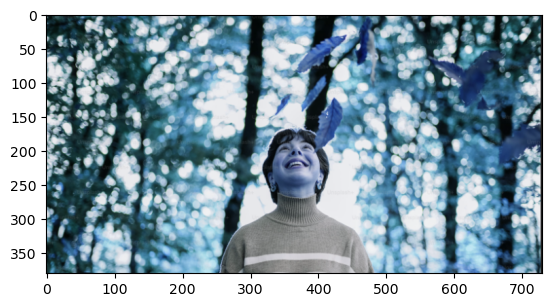

In [229]:
img = cv2.imread('data/testhappy/happy1.png')
plt.imshow(img)

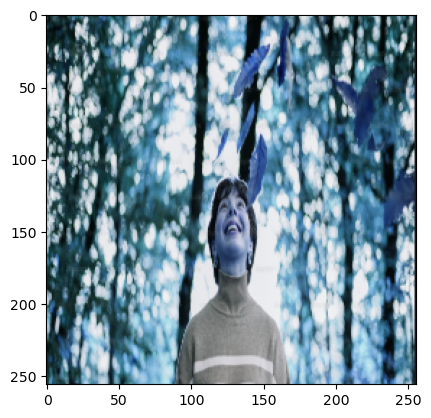

In [230]:
resize= tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [233]:
yhat = model.predict(np.expand_dims(resize/255,0))
yhat

1/1 [==============================] - 0s 30ms/step


array([[0.02283861]], dtype=float32)

In [237]:
imgsad = cv2.imread('data/testsad/sad1.png')
resize = tf.image.resize(imgsad,(256,256))
yhat = model.predict(np.expand_dims(resize/255,0))
yhat

1/1 [==============================] - 0s 19ms/step


array([[0.833758]], dtype=float32)